# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

<a id="1"></a>
# 1. Подготовка данных

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv('/datasets/Churn.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Признаки  
RowNumber — индекс строки в данных  
CustomerId — уникальный идентификатор клиента  
Surname — фамилия  
CreditScore — кредитный рейтинг  
Geography — страна проживания  
Gender — пол  
Age — возраст  
Tenure — количество недвижимости у клиента  
Balance — баланс на счёте  
NumOfProducts — количество продуктов банка, используемых клиентом  
HasCrCard — наличие кредитной карты  
IsActiveMember — активность клиента  
EstimatedSalary — предполагаемая зарплата  
Целевой признак  
Exited — факт ухода клиента  

In [ ]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


#### Вывод
RowNumber — столбец дублирует индекс, можно удалить.  
CustomerId — уникальный id тоже удаляем.  
Surname — фамилия, если не верить в гороскопы имен), тоже не несет полезной информации, удаляем.   
Geography, Gender — преобразовать методом One hot encoder.  
Tenure — заменим пропуски нулями.  
CreditScore, Age, Tenur, Balance, NumOfProducts, EstimatedSalary — масштабируем.  

<a id="11"></a>
### Предобработка данных

In [ ]:
# Удаляю лишние столбцы
data = data.drop(['RowNumber','CustomerId','Surname'], axis=1)

In [ ]:
# Заполняю пропуски на среднее
data['Tenure'] = data['Tenure'].fillna(data['Tenure'].mean()).astype('int64')

In [ ]:
# Избавляюсь от категориальных признаков
data = pd.get_dummies(data, drop_first=True)
data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


<a id="12"></a>
### Формирование выборок

In [ ]:
# Разбиваем на параметры и целевой признак
features=data.drop(['Exited'],axis=1)
target=data['Exited']

In [ ]:
# Разбиваем на тренировочную, тестовую и валидационную выборки

target = data['Exited']
features = data.drop('Exited', axis=1)

train_features, valid_features, train_target, valid_target = train_test_split(features, target, test_size=0.4, 
                                                                              random_state=12345)
valid_features, test_features, valid_target, test_target = train_test_split(valid_features, valid_target, test_size=0.5, 
                                                                              random_state=12345 )
print(train_features.shape, valid_features.shape, test_features.shape)
print(train_target.shape, valid_target.shape, test_target.shape)


(6000, 11) (2000, 11) (2000, 11)
(6000,) (2000,) (2000,)


In [ ]:
# Масштабируем численные признаки выборок для выравнивания весов
numeric=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
scaler=StandardScaler()
scaler.fit(train_features[numeric])
train_features[numeric]=scaler.transform(train_features[numeric])
valid_features[numeric]=scaler.transform(valid_features[numeric])
test_features[numeric]=scaler.transform(test_features[numeric])
train_features.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7479,-0.886751,-0.373192,1.109334,1.232271,-0.891560,1,0,-0.187705,0,1,1
3411,0.608663,-0.183385,1.109334,0.600563,-0.891560,0,0,-0.333945,0,0,0
6027,2.052152,0.480939,-0.700051,1.027098,0.830152,0,1,1.503095,1,0,1
1247,-1.457915,-1.417129,0.385580,-1.233163,0.830152,1,0,-1.071061,0,0,1
3716,0.130961,-1.132419,-1.061928,1.140475,-0.891560,0,0,1.524268,1,0,0


<a id="2"></a>
# 2. Исследование задачи

<a id="21"></a>
### Баланс данных

0    7963
1    2037
Name: Exited, dtype: int64

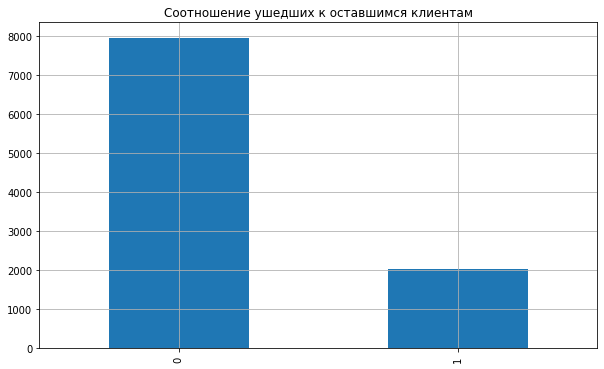

In [ ]:
data['Exited'].value_counts().plot(kind='bar', grid=True,figsize=(10,6),title='Соотношение ушедших к оставшимся клиентам')
data['Exited'].value_counts()

#### Вывод:
Имеется дисбаланс классов. 1:4 в пользу оставшихся клиентов. Это может привести модель к склонению в распространённый вариант ответа.

<a id="22"></a>
### Обучение моделей:
Решающее дерево  
Случайный лес  
Логистическая регрессия  

#### Обучим модели случайного дерева с перебором глубины, найдем гиперпараметры с наибольшей метрикой f1.

In [ ]:
f1_best = 0
depth_best = 0
for depth in range(7, 11):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(train_features, train_target)
    prediction = model.predict(valid_features)
    f1 = f1_score(valid_target, prediction)
    if f1>f1_best:
            f1_best=f1
            depth_best=depth
print('Max depth', depth_best,'F1-score', f1_best)

Max depth 9 F1-score 0.5722300140252455


Проведем оценку accuracy, precision, recall, F1, AUC-ROC на полученных гиперпараметрах

In [ ]:
model = DecisionTreeClassifier(random_state=12345, max_depth=9)
model.fit(train_features, train_target)
prediction = model.predict(valid_features)
print('Accuracy', accuracy_score(valid_target, prediction))
print('Precision', precision_score(valid_target, prediction))
print('Recall', recall_score(valid_target, prediction))
print('F1', f1_score(valid_target, prediction))
probabilities_valid = model.predict_proba(valid_features)[:, 1]
print("AUC-ROC", roc_auc_score(valid_target, probabilities_valid))

Accuracy 0.8475
Precision 0.6915254237288135
Recall 0.4880382775119617
F1 0.5722300140252455
AUC-ROC 0.78270041556022


#### Обучение модели случайного леса с перебором гиперпараметров, которые дают наибольшую метрику f1.

In [ ]:
f1_best = 0
estim_best = 0
depth_best = 0

for estim in range (60, 63):
    for depth in range(10, 12):
        model = RandomForestClassifier(n_estimators=estim, max_depth=depth, random_state=12345)
        model.fit(train_features, train_target)
        prediction = model.predict(valid_features)
        f1 = f1_score(valid_target, prediction)
        if f1>f1_best:
            f1_best=f1
            estim_best=estim
            depth_best=depth
        

print('n_estimators =', estim_best, 'Max depth', depth_best, 'F1-score', f1_best)

n_estimators = 62 Max depth 11 F1-score 0.588957055214724


Проведем оценку accuracy, precision, recall, F1, AUC-ROC на полученных гиперпараметрах

In [ ]:
model = RandomForestClassifier(n_estimators=60, max_depth=11, random_state=12345)
model.fit(train_features, train_target)
prediction = model.predict(valid_features)
print('Accuracy', accuracy_score(valid_target, prediction))
print('Precision', precision_score(valid_target, prediction))
print('Recall', recall_score(valid_target, prediction))
print('F1', f1_score(valid_target, prediction))
probabilities_valid = model.predict_proba(valid_features)[:, 1]
print("AUC-ROC", roc_auc_score(valid_target, probabilities_valid))

Accuracy 0.8655
Precision 0.8170212765957446
Recall 0.45933014354066987
F1 0.5880551301684532
AUC-ROC 0.8474464520109607


#### Обучение и оценка метрик с помощью модели Логистической регрессии

In [ ]:
model =  LogisticRegression()
model.fit(train_features, train_target)
prediction = model.predict(valid_features)
print('Accuracy', accuracy_score(valid_target, prediction))
print('Precision', precision_score(valid_target, prediction))
print('Recall', recall_score(valid_target, prediction))
print('F1', f1_score(valid_target, prediction))
probabilities_valid = model.predict_proba(valid_features)[:, 1]
print("AUC-ROC", roc_auc_score(valid_target, probabilities_valid))

Accuracy 0.8025
Precision 0.5657142857142857
Recall 0.23684210526315788
F1 0.33389544688026984
AUC-ROC 0.758722530380658


#### Вывод  
Из-за несбалансированности данных, все модели имеют recall ниже, чем percision, это влияет на F-меру. Модель случайного леса имеет метрику близкую к необходимой 


<a id="3"></a>
# 3. Борьба с дисбалансом

<a id="31"></a>
#### Обучение моделей с параметром автоматической регулировки весов.

In [ ]:
# Модель случайного дерева
# Подбор гиперпараметров
f1_best = 0
depth_best = 0
for depth in range(2, 18): 
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model.fit(train_features, train_target)
    prediction = model.predict(valid_features)
    f1 = f1_score(valid_target, prediction)
    if f1>f1_best:
            f1_best=f1
            depth_best=depth
print('Max depth', depth_best,'F1-score', f1_best)

# Расчет метрик
model = DecisionTreeClassifier(random_state=12345, max_depth=depth_best, class_weight='balanced')
model.fit(train_features, train_target)
prediction = model.predict(valid_features)
print('Accuracy', accuracy_score(valid_target, prediction))
print('Precision', precision_score(valid_target, prediction))
print('Recall', recall_score(valid_target, prediction))
print('F1', f1_score(valid_target, prediction))
probabilities_valid = model.predict_proba(valid_features)[:, 1]
print("AUC-ROC", roc_auc_score(valid_target, probabilities_valid))


Max depth 5 F1-score 0.5963791267305644
Accuracy 0.8105
Precision 0.5374280230326296
Recall 0.6698564593301436
F1 0.5963791267305644
AUC-ROC 0.8310244134068074


In [ ]:
# Модель случайного леса
# Подбор гиперпараметров
f1_best = 0
estim_best = 0
depth_best = 0

for estim in range (91, 93):
    for depth in range(7, 9):
        model = RandomForestClassifier(n_estimators=estim, max_depth=depth, random_state=12345, class_weight='balanced')
        model.fit(train_features, train_target)
        prediction = model.predict(valid_features)
        f1 = f1_score(valid_target, prediction)
        if f1>f1_best:
            f1_best=f1
            estim_best=estim
            depth_best=depth      
print('n_estimators =', estim_best, 'Max depth', depth_best, 'F1-score', f1_best)

# Расчет метрик
model = RandomForestClassifier(n_estimators=estim_best, max_depth=depth_best, random_state=12345, class_weight='balanced')
model.fit(train_features, train_target)
prediction = model.predict(valid_features)
print('Accuracy', accuracy_score(valid_target, prediction))
print('Precision', precision_score(valid_target, prediction))
print('Recall', recall_score(valid_target, prediction))
print('F1', f1_score(valid_target, prediction))
probabilities_valid = model.predict_proba(valid_features)[:, 1]
print("AUC-ROC", roc_auc_score(valid_target, probabilities_valid))

n_estimators = 92 Max depth 8 F1-score 0.6407982261640799
Accuracy 0.838
Precision 0.5971074380165289
Recall 0.6913875598086124
F1 0.6407982261640799
AUC-ROC 0.8552949146801032


In [ ]:
# Модель логистическая регрессия
model =  LogisticRegression(class_weight='balanced')
model.fit(train_features, train_target)
prediction = model.predict(valid_features)
print('Accuracy', accuracy_score(valid_target, prediction))
print('Precision', precision_score(valid_target, prediction))
print('Recall', recall_score(valid_target, prediction))
print('F1', f1_score(valid_target, prediction))
probabilities_valid = model.predict_proba(valid_features)[:, 1]
print("AUC-ROC", roc_auc_score(valid_target, probabilities_valid))

Accuracy 0.7015
Precision 0.38050734312416556
Recall 0.6818181818181818
F1 0.48843187660668386
AUC-ROC 0.6942592805424663


#### Вывод:  
F1 мера стала лучше

<a id="32"></a>
#### С помощью написанно функции Downsampling и уменьшим колличество target=0

In [ ]:
def downsampling(features,target,fraction):
    #Разделяем выборку по значениям целевой функции
    features_null=features[target==0]
    features_one=features[target==1]
    target_null=target[target==0]
    target_one=target[target==1]
    
    #уменьшаем путем умножения на десятую часть и соединяем обратно
    downsampling_features=pd.concat([features_null.sample(frac=fraction,random_state=12345)]+[features_one])
    downsampling_target=pd.concat([target_null.sample(frac=fraction,random_state=12345)]+[target_one])
    
    # Перемешиваем
    downsampling_features,downsampling_target=shuffle(downsampling_features,downsampling_target,random_state=12345)
    
    return downsampling_features,downsampling_target

In [ ]:
features_balance,target_balance=downsampling(features,target,0.25)

In [ ]:
# Модель случайного дерева
# Подбор гиперпараметров
f1_best = 0
depth_best = 0
for depth in range(2, 18): #(уменьшил ранг чтобы не грузить сервер, перебрал все заранее)
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_balance,target_balance)
    prediction = model.predict(valid_features)
    f1 = f1_score(valid_target, prediction)
    if f1>f1_best:
            f1_best=f1
            depth_best=depth
print('Max depth', depth_best,'F1-score', f1_best)

# Расчет метрик
model = DecisionTreeClassifier(random_state=12345, max_depth=depth_best)
model.fit(features_balance,target_balance)
prediction = model.predict(valid_features)
print('Accuracy', accuracy_score(valid_target, prediction))
print('Precision', precision_score(valid_target, prediction))
print('Recall', recall_score(valid_target, prediction))
print('F1', f1_score(valid_target, prediction))
probabilities_valid = model.predict_proba(valid_features)[:, 1]
print("AUC-ROC", roc_auc_score(valid_target, probabilities_valid))

Max depth 4 F1-score 0.4020304568527919
Accuracy 0.7055
Precision 0.3492063492063492
Recall 0.47368421052631576
F1 0.4020304568527919
AUC-ROC 0.6354404212461968


In [ ]:
# Модель случайного леса
# Подбор гиперпараметров
f1_best = 0
estim_best = 0
depth_best = 0

for estim in range (30, 31):
    for depth in range(9, 10):
        model = RandomForestClassifier(n_estimators=estim, max_depth=depth, random_state=12345)
        model.fit(features_balance,target_balance)
        prediction = model.predict(valid_features)
        f1 = f1_score(valid_target, prediction)
        if f1>f1_best:
            f1_best=f1
            estim_best=estim
            depth_best=depth      
print('n_estimators =', estim_best, 'Max depth', depth_best, 'F1-score', f1_best)

# Расчет метрик
model = RandomForestClassifier(n_estimators=estim_best, max_depth=depth_best, random_state=12345)
model.fit(features_balance,target_balance)
prediction = model.predict(valid_features)
print('Accuracy', accuracy_score(valid_target, prediction))
print('Precision', precision_score(valid_target, prediction))
print('Recall', recall_score(valid_target, prediction))
print('F1', f1_score(valid_target, prediction))
probabilities_valid = model.predict_proba(valid_features)[:, 1]
print("AUC-ROC", roc_auc_score(valid_target, probabilities_valid))

n_estimators = 30 Max depth 9 F1-score 0.34763948497854075
Accuracy 0.544
Precision 0.2479591836734694
Recall 0.5813397129186603
F1 0.34763948497854075
AUC-ROC 0.555519934187843


In [ ]:
# Модель логистическая регрессия
model =  LogisticRegression()
model.fit(features_balance,target_balance)
prediction = model.predict(valid_features)
print('Accuracy', accuracy_score(valid_target, prediction))
print('Precision', precision_score(valid_target, prediction))
print('Recall', recall_score(valid_target, prediction))
probabilities_valid = model.predict_proba(valid_features)[:, 1]
print("AUC-ROC", roc_auc_score(valid_target, probabilities_valid))

Accuracy 0.7375
Precision 0.4115702479338843
Recall 0.5956937799043063
AUC-ROC 0.7452198476884084


#### Вывод:  
Метрики стали заметно хуже, такой баланс данных не подходит

<a id="33"></a>
#### С помощью написанно функции Upsampling увеличим количество колличество target=0

In [ ]:
def upsampling (features,target,repeat):
    #Разделяем выборку по значениям целевой функции
    target_one=target[target==1]
    target_null=target[target==0]
    features_one=features[target==1]
    features_null=features[target==0]
    
    #Увеличиваем и соединяем обратно
    upsampling_features=pd.concat([features_null]+[features_one]*repeat)
    upsampling_target=pd.concat([target_null]+[target_one]*repeat)
    
    # Перемешиваем
    upsampling_features,upsampling_target=shuffle(upsampling_features,upsampling_target,random_state=12345)
    
    return upsampling_features,upsampling_target


In [ ]:
features_balance,target_balance=upsampling(train_features,train_target,4)

In [ ]:
# Модель случайного дерева
# Подбор гиперпараметров
f1_best = 0
depth_best = 0
for depth in range(4, 8):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_balance,target_balance)
    prediction = model.predict(valid_features)
    f1 = f1_score(valid_target, prediction)
    if f1>f1_best:
            f1_best=f1
            depth_best=depth
print('Max depth', depth_best,'F1-score', f1_best)

# Расчет метрик
model = DecisionTreeClassifier(random_state=12345, max_depth=depth_best)
model.fit(features_balance,target_balance)
prediction = model.predict(valid_features)
print('Accuracy', accuracy_score(valid_target, prediction))
print('Precision', precision_score(valid_target, prediction))
print('Recall', recall_score(valid_target, prediction))
print('F1', f1_score(valid_target, prediction))
probabilities_valid = model.predict_proba(valid_features)[:, 1]
print("AUC-ROC", roc_auc_score(valid_target, probabilities_valid))
fpr_tree, tpr_tree, thresholds = roc_curve(valid_target, probabilities_valid)

Max depth 5 F1-score 0.5963791267305644
Accuracy 0.8105
Precision 0.5374280230326296
Recall 0.6698564593301436
F1 0.5963791267305644
AUC-ROC 0.8310244134068074


In [ ]:
# Модель случайного леса
# Подбор гиперпараметров
f1_best = 0
estim_best = 0
depth_best = 0

for estim in range (56, 58):
    for depth in range(8, 10):
        model = RandomForestClassifier(n_estimators=estim, max_depth=depth, random_state=12345)
        model.fit(features_balance,target_balance)
        prediction = model.predict(valid_features)
        f1 = f1_score(valid_target, prediction)
        if f1>f1_best:
            f1_best=f1
            estim_best=estim
            depth_best=depth      
print('n_estimators =', estim_best, 'Max depth', depth_best, 'F1-score', f1_best)

# Расчет метрик
model = RandomForestClassifier(n_estimators=estim_best, max_depth=depth_best, random_state=12345)
model.fit(features_balance,target_balance)
prediction = model.predict(valid_features)
print('Accuracy', accuracy_score(valid_target, prediction))
print('Precision', precision_score(valid_target, prediction))
print('Recall', recall_score(valid_target, prediction))
print('F1', f1_score(valid_target, prediction))
probabilities_valid = model.predict_proba(valid_features)[:, 1]
print("AUC-ROC", roc_auc_score(valid_target, probabilities_valid))
fpr_forest, tpr_forest, thresholds = roc_curve(valid_target, probabilities_valid)

n_estimators = 57 Max depth 9 F1-score 0.6328042328042329
Accuracy 0.8185
Precision 0.5500910746812386
Recall 0.722488038277512
F1 0.624612202688728
AUC-ROC 0.8548669541915932


In [ ]:
# Модель логистическая регрессия
model =  LogisticRegression()
model.fit(features_balance,target_balance)
prediction = model.predict(valid_features)
print('Accuracy', accuracy_score(valid_target, prediction))
print('Precision', precision_score(valid_target, prediction))
print('Recall', recall_score(valid_target, prediction))
print('F1', f1_score(valid_target, prediction))
probabilities_valid = model.predict_proba(valid_features)[:, 1]
print("AUC-ROC", roc_auc_score(valid_target, prediction))
fpr_log, tpr_log, thresholds = roc_curve(valid_target, probabilities_valid)

Accuracy 0.7015
Precision 0.38050734312416556
Recall 0.6818181818181818
F1 0.48843187660668386
AUC-ROC 0.6942592805424663


<a id="34"></a>
#### Визуализируем AUC-ROC посредством графика площади

<Figure size 432x288 with 0 Axes>

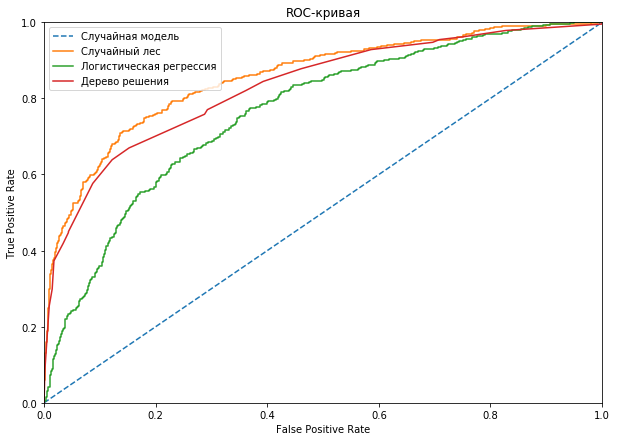

In [ ]:
plt.figure()

plt.figure(figsize=(10,7))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot(fpr_forest,tpr_forest)
plt.plot(fpr_log,tpr_log)
plt.plot(fpr_tree,tpr_tree)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(('Случайная модель','Случайный лес','Логистическая регрессия','Дерево решения'),
           loc= 'upper left') 
plt.show()

Наилучшее качество модели было достигнуто при взвешивании классов параметром class_weight='balanced' с использование случайного леса. Так же метрика AUC-ROC Случайного леса лучше остальных

<a id="4"></a>
# 4. Тестирование модели

<a id="41"></a>
### Обучение после балансировки данных

<a id="42"></a>
### Обучим финальную модель

In [ ]:
model_final = RandomForestClassifier(n_estimators=92, max_depth=8, random_state=12345, class_weight='balanced')
model_final.fit(train_features, train_target)
prediction = model_final.predict(valid_features)
print('Accuracy', accuracy_score(valid_target, prediction))
print('Precision', precision_score(valid_target, prediction))
print('Recall', recall_score(valid_target, prediction))
print('F1', f1_score(valid_target, prediction))
probabilities_valid = model_final.predict_proba(valid_features)[:, 1]
print("AUC-ROC", roc_auc_score(valid_target, probabilities_valid))

Accuracy 0.838
Precision 0.5971074380165289
Recall 0.6913875598086124
F1 0.6407982261640799
AUC-ROC 0.8552949146801032


#### Вывод:  
Для финальной модели выберем модель случайного леса с параметрами: n_estimators = 159 Max depth 11

<a id="43"></a>
### Проверим на адекватность

In [ ]:
#Создаем константную модель
target_predict_constant = pd.Series([0]*len(valid_target))
target_predict_constant.value_counts()

0    2000
dtype: int64

In [ ]:
#Сравним показатель точности (accuracy_score) константной модели и финальной
print('accuracy_score константой модели:', accuracy_score(valid_target, target_predict_constant))
print('accuracy_score финальной модели:', accuracy_score(valid_target, prediction))

accuracy_score константой модели: 0.791
accuracy_score финальной модели: 0.838


In [ ]:
#Сравним AUC-ROC, остальные метрики не работают на константной модели.
print('AUC-ROC константой модели:', roc_auc_score(valid_target, target_predict_constant))
print('AUC-ROC финальной модели:', roc_auc_score(valid_target, probabilities_valid))

AUC-ROC константой модели: 0.5
AUC-ROC финальной модели: 0.8552949146801032


#### Вывод:  
Метрики финальной модели лучше, чем константной, модель является адекватной

<a id="44"></a>
### Тестируем модель

In [ ]:
model_final
prediction = model_final.predict(test_features)
print('Accuracy', accuracy_score(test_target, prediction))
print('Precision', precision_score(test_target, prediction))
print('Recall', recall_score(test_target, prediction))
print('F1', f1_score(test_target, prediction))
probabilities_valid = model_final.predict_proba(test_features)[:, 1]
print("AUC-ROC", roc_auc_score(test_target, probabilities_valid))
fpr, tpr, thresholds = roc_curve(test_target, probabilities_valid)

Accuracy 0.8205
Precision 0.564
Recall 0.6666666666666666
F1 0.6110509209100758
AUC-ROC 0.8550948849522765


<Figure size 432x288 with 0 Axes>

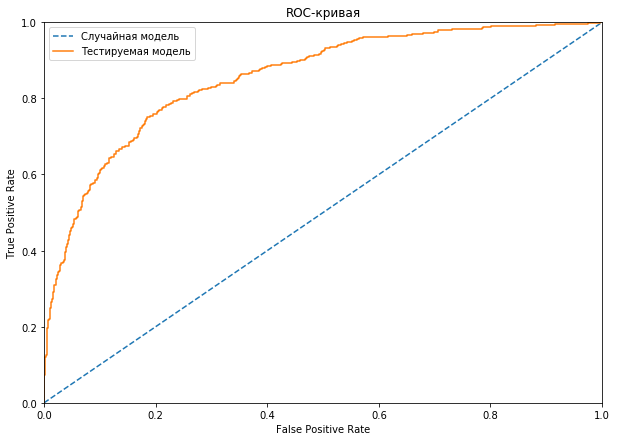

In [ ]:
plt.figure()

plt.figure(figsize=(10,7))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(('Случайная модель','Тестируемая модель'),
           loc= 'upper left') 
plt.show()

<a id="5"></a>
### Вывод: 
Модели со сбалансированными данными путем увеличения количества недостающих классов показали себя лучше других видов баланса и несбалансированных моделей.
Финальная модель на тестовой выборке достигла заданного порога и показывает адекватные результаты (AUC-ROC 0.76)
Модель с большой вероятностью предскажет уход клиента из банка за счет высокой точности (0.597)
Модель находит большую часть ушедших клиентов на тестовой выборке (полнота = 0.65)

#### Off top вывод

На гистограмме видны всплески ухода клиентов в районе 50-60 лет. Этот возраст сопровождается высокой мужской смертностью. Возможно, отток клиентов связан с закрытием счетов по причине смерти. Этого параметра нахватает в данных.

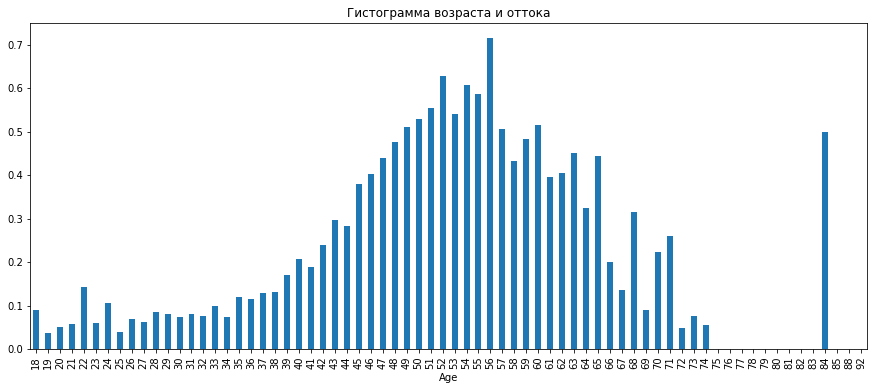

In [ ]:
data.groupby('Age')['Exited'].mean().plot(figsize=(15,6),kind='bar',title='Гистограмма возраста и оттока')
plt.show()